## Data webscrape

In [4]:
import praw
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from datetime import datetime

# Your Reddit API credentials here
REDDIT_CLIENT_ID = 
REDDIT_CLIENT_SECRET = 
REDDIT_USER_AGENT = 
KEYWORDS = ["raining", "storm", "thunder", "pouring", "lightning", "hail", "flooding"]
SUBREDDIT = "newjersey"
MAX_POSTS = 100  
analyzer = SentimentIntensityAnalyzer()

def analyze_sentiment(text):
    sentiment = analyzer.polarity_scores(text)
    compound = sentiment["compound"]
    label = (
        "positive" if compound > 0.05 else
        "negative" if compound < -0.05 else
        "neutral"
    )
    return compound, label

def scrape_local_subreddit():
    reddit = praw.Reddit(
        client_id=REDDIT_CLIENT_ID,
        client_secret=REDDIT_CLIENT_SECRET,
        user_agent=REDDIT_USER_AGENT,
    )

    all_data = []

    print(f"Scraping r/{SUBREDDIT} for weather-related posts...")

    submissions = reddit.subreddit(SUBREDDIT).new(limit=MAX_POSTS)

    for post in submissions:
        post_text = post.title + " " + post.selftext
        matched_keywords = [kw for kw in KEYWORDS if kw.lower() in post_text.lower()]
        
        if matched_keywords:
            compound, label = analyze_sentiment(post_text)
            all_data.append({
                "timestamp": datetime.utcfromtimestamp(post.created_utc).strftime('%Y-%m-%d %H:%M:%S'),
                "keyword": matched_keywords[0],  
                "title": post.title,
                "selftext": post.selftext,
                "sentiment": compound,
                "label": label,
                "subreddit": SUBREDDIT,
                "url": post.url,
            })

    df = pd.DataFrame(all_data)
    if df.empty:
        print("No relevant posts found.")
    else:
        print(df[["timestamp", "keyword", "label", "title"]])
        df.to_csv(f"{SUBREDDIT}_weather_sentiment.csv", index=False)
        print(f"Saved to {SUBREDDIT}_weather_sentiment.csv")

if __name__ == "__main__":
    scrape_local_subreddit()


Scraping r/newjersey for weather-related posts...
             timestamp   keyword     label  \
0  2025-07-01 22:13:25     storm  positive   
1  2025-07-01 21:42:06  flooding  positive   
2  2025-07-01 20:54:32   thunder  negative   
3  2025-07-01 04:46:31   thunder  positive   
4  2025-07-01 00:55:47     storm  negative   

                                         title  
0                               Storms-a-comin  
1                              This isn’t good  
2                                  Triple boom  
3            Low rumbling outside in NE Essex?  
4  Crazy storm in Princeton Jct and Plainsboro  
Saved to newjersey_weather_sentiment.csv


## Database Component

In [ ]:
import mysql.connector
import pandas as pd


df = pd.read_csv("newjersey_weather_sentiment.csv")
#replace with your own connection settings
conn = mysql.connector.connect(
    host=" ",   
    user=" ",
    password=" ",
    database="weather_db",
    port=3306
)
cur = conn.cursor()
for _, row in df.iterrows():
    cur.execute("""
        INSERT INTO weather_posts (timestamp, keyword, title, selftext, sentiment, label, subreddit, url)
        VALUES (%s, %s, %s, %s, %s, %s, %s, %s)
    """, (
        row["timestamp"],
        row["keyword"],
        row["title"],
        row["selftext"],
        float(row["sentiment"]) if not pd.isna(row["sentiment"]) else None,
        row["label"],
        row["subreddit"],
        row["url"]
    ))

conn.commit()
cur.close()
conn.close()

# below is debug code to check if your msql is work correctly
# print("Data inserted into MySQL from WSL")

## Exploratory Data Analysis

In [6]:
import mysql.connector
import pandas as pd

#replace with your own connection settings
conn = mysql.connector.connect(
    host=" ",
    user=" ",
    password=" ",
    database="weather_db",
    port=3306
)

query = "SELECT * FROM weather_posts;"
df = pd.read_sql(query, conn)
conn.close()

print(df.head())

   id           timestamp   keyword  \
0   1 2025-07-01 22:13:25     storm   
1   2 2025-07-01 21:42:06  flooding   
2   3 2025-07-01 20:54:32   thunder   
3   4 2025-07-01 04:46:31   thunder   
4   5 2025-07-01 00:55:47     storm   

                                         title  \
0                               Storms-a-comin   
1                              This isn’t good   
2                                  Triple boom   
3            Low rumbling outside in NE Essex?   
4  Crazy storm in Princeton Jct and Plainsboro   

                                            selftext  sentiment     label  \
0            Bonus points if you know where this is!     0.5848  positive   
1  We’re having some serious flooding here in Nep...     0.3818  positive   
2  Anybody just hear 3 loud booms in central jers...    -0.3215  negative   
3  We’ve heard this low rumbling passing by for 3...     0.6978  positive   
4  Was it a tornado that ripped through the area ...    -0.7430  negative   

 

/tmp/ipykernel_667/1720981357.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql(query, conn)


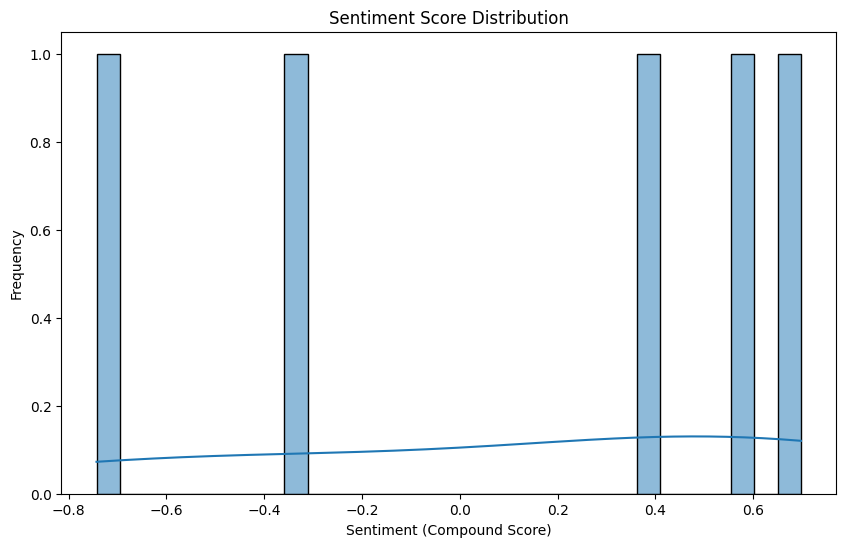

label
positive    3
negative    2
Name: count, dtype: int64


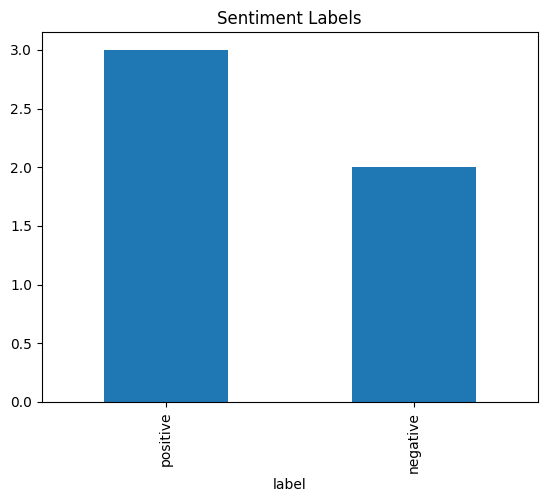

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

df["timestamp"] = pd.to_datetime(df["timestamp"])

# Sentiment histogram
plt.figure(figsize=(10, 6))
sns.histplot(df["sentiment"], kde=True, bins=30)
plt.title("Sentiment Score Distribution")
plt.xlabel("Sentiment (Compound Score)")
plt.ylabel("Frequency")
plt.show()
print(df["label"].value_counts())
df["label"].value_counts().plot(kind="bar", title="Sentiment Labels")
plt.show()

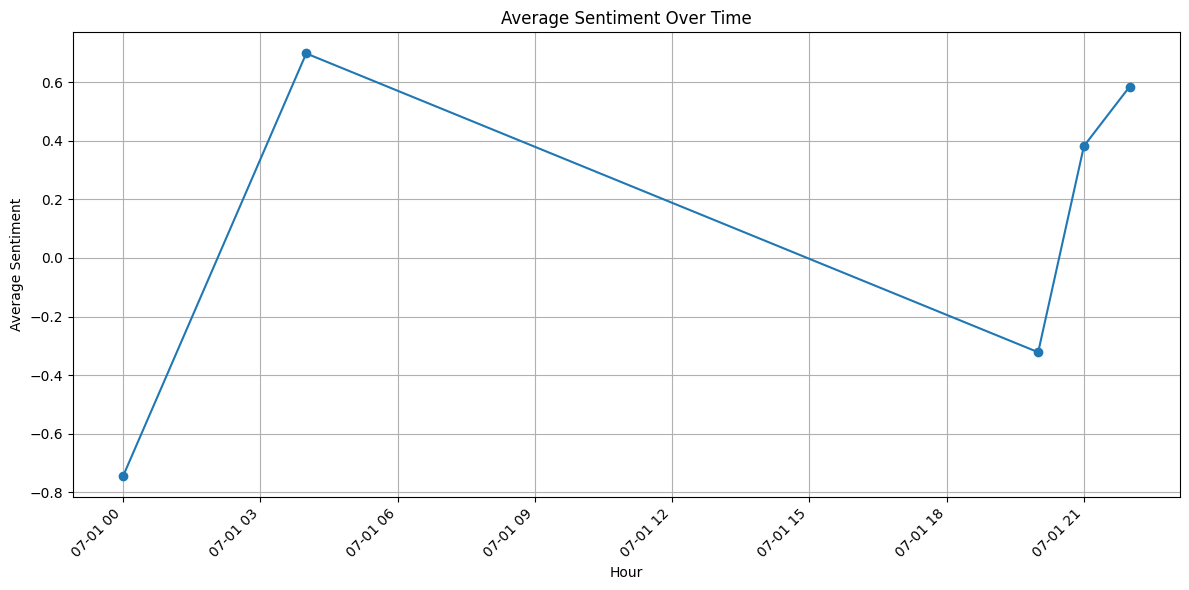

In [8]:
df['hour'] = df['timestamp'].dt.floor('H')
hourly_sentiment = df.groupby('hour')['sentiment'].mean()

# Plot sentiment over time
plt.figure(figsize=(12, 6))
hourly_sentiment.plot(marker='o', title="Average Sentiment Over Time")
plt.xlabel("Hour")
plt.ylabel("Average Sentiment")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [9]:
df["location"] = "New Jersey"

In [19]:
import pandas as pd
import requests

df['timestamp'] = pd.to_datetime(df['timestamp'])
df['time_bucket'] = df['timestamp'].dt.floor('H')
start_date = df['time_bucket'].min().strftime('%Y-%m-%d')
end_date = df['time_bucket'].max().strftime('%Y-%m-%d')

# Coordinates for New Jersey, changed if you changed subreddit
latitude = 40.2170
longitude = -74.7429
weather_url = (
    f"https://archive-api.open-meteo.com/v1/archive?"
    f"latitude={latitude}&longitude={longitude}"
    f"&start_date={start_date}&end_date={end_date}"
    f"&hourly=precipitation"
    f"&timezone=America/New_York"
)

response = requests.get(weather_url)
data = response.json()
if 'hourly' not in data or 'time' not in data['hourly'] or 'precipitation' not in data['hourly']:
    raise ValueError("Weather API response is missing expected hourly data.")

df_weather = pd.DataFrame({
    'time_bucket': pd.to_datetime(data['hourly']['time']),
    'precipitation': data['hourly']['precipitation']
})

df_sentiment_hourly = df.groupby('time_bucket')['sentiment'].mean().reset_index()
df_merged = pd.merge(df_sentiment_hourly, df_weather, on='time_bucket', how='left')
print(df_merged.head())

          time_bucket  sentiment  precipitation
0 2025-07-01 00:00:00    -0.7430            0.0
1 2025-07-01 04:00:00     0.6978            0.1
2 2025-07-01 20:00:00    -0.3215            0.2
3 2025-07-01 21:00:00     0.3818            1.0
4 2025-07-01 22:00:00     0.5848            0.6


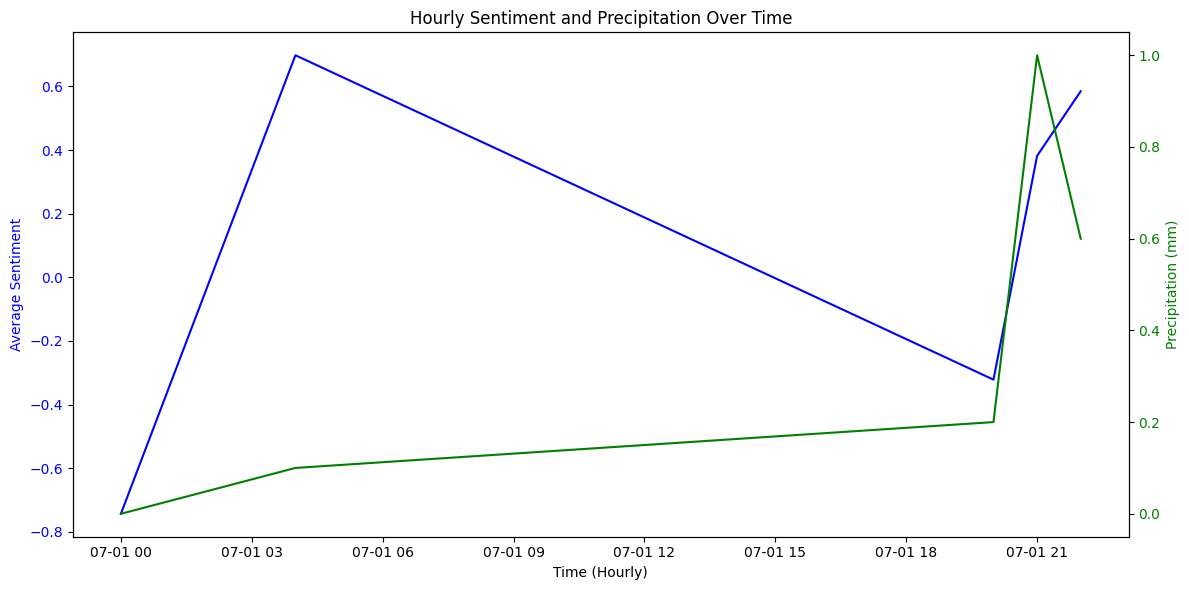

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

fig, ax1 = plt.subplots(figsize=(12,6))
ax1.plot(df_merged['time_bucket'], df_merged['sentiment'], color='blue', label='Avg Sentiment')
ax1.set_xlabel('Time (Hourly)')
ax1.set_ylabel('Average Sentiment', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')
ax2 = ax1.twinx()
ax2.plot(df_merged['time_bucket'], df_merged['precipitation'], color='green', label='Precipitation (mm)')
ax2.set_ylabel('Precipitation (mm)', color='green')
ax2.tick_params(axis='y', labelcolor='green')
plt.title('Hourly Sentiment and Precipitation Over Time')
fig.tight_layout()
plt.show()